In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

First of all, we need the dataset. We can download and it using the following commands.

In [2]:
#!curl -O http://alice.adase.org/media/downloads/dataset_Kids_v0.2_TLiCoxo.zip
#!unzip dataset_Kids.zip

# !curl -O http://alice.adase.org/media/downloads/dataset_mu_rhythm_1.1.zip
# !unzip dataset_mu_rhythm_1.1.zip

In [3]:
from alice_ml.preprocessing import load_dataset

path = '/Users/beliaevaaleksandra/Downloads/dataset_mu_rhythm_1.1'

data, raw_annotations = load_dataset(path, preload=False)

In [4]:
def get_target_distribution(annotations):
    # Exclude non-numeric columns like 'user_hash' and other potential object-type columns
    flag_columns = annotations.select_dtypes(include=[bool, int, float]).columns
    # Perform groupby on 'ic_id' and calculate the mean for the flag columns
    return annotations.groupby('ic_id')[flag_columns].mean().apply(lambda x: x.value_counts())
get_target_distribution(raw_annotations)

,comment,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_eyes_blinks,flag_muscles_and_movement,flag_muscles,flag_movement,flag_heart,flag_noise,flag_line_noise,flag_ch_noise,flag_uncertain,flag_other
0.000000,NaN,97.0,130.0,120.0,85.0,132,140.0,124,138.0,146.0,148.0,149.0,146.0,149.0,147.0,127.0,149.0
0.500000,NaN,3.0,2.0,NaN,7.0,9,7.0,19,2.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN
0.666667,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.000000,NaN,49.0,17.0,29.0,57.0,7,2.0,5,9.0,1.0,1.0,NaN,3.0,NaN,2.0,20.0,NaN


In [5]:
def propogate_labels(annotations):
    return annotations.assign(flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1)) \
                      .drop(columns=['flag_line_noise'])

annotations = propogate_labels(raw_annotations)
get_target_distribution(annotations)

,comment,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_eyes_blinks,flag_muscles_and_movement,flag_muscles,flag_movement,flag_heart,flag_noise,flag_ch_noise,flag_uncertain,flag_other
0.000000,NaN,97.0,130.0,120.0,85.0,132,140.0,124,138.0,146.0,148.0,149.0,146.0,147.0,127.0,149.0
0.500000,NaN,3.0,2.0,NaN,7.0,9,7.0,19,2.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN
0.666667,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.000000,NaN,49.0,17.0,29.0,57.0,7,2.0,5,9.0,1.0,1.0,NaN,3.0,2.0,20.0,NaN


In [6]:
from alice_ml.preprocessing import build_target_df
targets = build_target_df(annotations, weights='uniform', strategy='mean', threshold=0.33)

targets[['flag_alpha', 'flag_mu', 'flag_heart']] = build_target_df(annotations, ['flag_alpha', 'flag_mu', 'flag_heart'], strategy='majority')

print(targets.sum())
targets = targets.loc[:, (targets.mean(axis=0) > 0.05) & (targets.all(axis=0) < 0.95)]
targets.head()

flag_brain                   49
flag_alpha                   19
flag_mu                      29
flag_eyes                    64
flag_eyes_h                  11
flag_eyes_v                   3
flag_eyes_blinks              6
flag_muscles_and_movement     8
flag_muscles                  1
flag_movement                 1
flag_heart                    0
flag_noise                    3
flag_ch_noise                 2
flag_uncertain               21
flag_other                    0
dtype: int64


,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_muscles_and_movement,flag_uncertain
ic_id,,,,,,,
IC001181,False,False,False,True,False,False,False
IC001182,True,False,False,False,False,False,False
IC001183,False,False,False,False,False,False,True
IC001184,False,False,False,False,False,False,True
IC001185,True,False,False,False,False,False,True


In [7]:
targets1 = {
    'ic_id': [],
    'flag_alpha' : [],
    'flag_mu': [],
    'flag_brain':[],
    'flag_eyes':[],
    'flag_eyes_h':[],
    'flag_uncertain':[]
}

In [8]:
for k in data.keys():
    if k in targets.index:
        continue
    else:
        targets1['ic_id'].append(k)
        targets1['flag_alpha'].append(False)
        targets1['flag_mu'].append(False)
        targets1['flag_brain'].append(False)
        targets1['flag_eyes'].append(False)
        targets1['flag_eyes_h'].append(False)
        targets1['flag_uncertain'].append(False)

In [9]:
targets = pd.concat([targets, pd.DataFrame(targets1).set_index('ic_id')])

In [10]:
targets = targets.fillna(False)


/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_4100/4277948533.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  targets = targets.fillna(False)


In [11]:
targets.shape, len(data.keys())

((527, 7), 527)

# Testing of new features in ML models

In [12]:
from alice_ml.features import build_feature_df

features = build_feature_df(data)
features

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use fl

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,...,average_persistence_with_phase,spatial_persistence,A_peaks,A_plateaus,A_peaks_freq,A_plateaus_freq,pca1,pca2,avg_persistence,max_persistence
IC001181,2.394026,14.074256,0.350957,0.020189,0.030888,0.226681,0.027488,0.031416,0.147364,-0.122794,...,1.429672,0.144175,0.074022,0.175978,9.265428,8.293834,0.099706,-0.285821,0.027365,0.228620
IC001182,-0.202781,78.412312,0.060472,0.002325,0.053063,0.218715,0.004291,0.004950,0.183362,-0.025954,...,1.340806,0.121335,0.107542,0.347765,8.435934,7.632316,0.046863,-0.244263,0.023887,0.144346
IC001183,0.217014,137.248558,0.052225,-0.002635,0.065720,0.311969,0.003769,0.005342,0.074177,-0.027691,...,1.292065,0.068231,0.093575,0.117318,9.645950,9.558845,0.156498,-0.229528,0.013144,0.036473
IC001184,1.983181,74.136798,-0.192816,-0.020441,0.088582,0.246820,0.001432,0.001503,-0.127449,0.156610,...,1.230299,0.076154,0.067039,0.076816,10.576282,10.707148,-0.236639,0.306388,0.034190,0.140988
IC001185,0.035117,180.334305,-0.142686,-0.013640,0.000192,0.308996,0.004359,0.004855,0.020297,0.144126,...,1.295255,0.089498,0.479050,0.671788,9.926716,9.512111,0.090920,-0.394789,0.018630,0.079815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IC001703,-0.084515,2.230707,0.019098,-0.071933,0.040540,0.138968,0.000114,0.000000,0.093972,-0.065988,...,1.001624,0.049024,0.276018,0.321267,10.462241,10.323954,-0.022159,0.110345,0.028845,0.304367
IC001704,-0.257739,2.887641,-0.086538,-0.036633,0.051408,0.085438,0.000133,0.000000,0.024734,0.165392,...,0.963620,0.138944,0.235294,0.330317,10.187674,9.910158,-0.160349,-0.123247,0.025383,0.102762
IC001705,-0.326352,5.647878,0.114341,-0.002898,0.099278,0.240965,0.000090,0.000030,0.078411,-0.033466,...,0.860711,0.114250,0.031674,0.045249,10.486019,10.682726,-0.152410,-0.062066,0.031931,0.213942
IC001706,-0.392827,1.563865,0.138463,0.184928,0.027151,0.543770,0.000000,0.000000,-0.024452,0.041361,...,0.810406,0.187820,0.013575,0.013575,8.433200,8.433200,0.045762,-0.186324,0.019117,0.149624


In [13]:
features

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,...,average_persistence_with_phase,spatial_persistence,A_peaks,A_plateaus,A_peaks_freq,A_plateaus_freq,pca1,pca2,avg_persistence,max_persistence
IC001181,2.394026,14.074256,0.350957,0.020189,0.030888,0.226681,0.027488,0.031416,0.147364,-0.122794,...,1.429672,0.144175,0.074022,0.175978,9.265428,8.293834,0.099706,-0.285821,0.027365,0.228620
IC001182,-0.202781,78.412312,0.060472,0.002325,0.053063,0.218715,0.004291,0.004950,0.183362,-0.025954,...,1.340806,0.121335,0.107542,0.347765,8.435934,7.632316,0.046863,-0.244263,0.023887,0.144346
IC001183,0.217014,137.248558,0.052225,-0.002635,0.065720,0.311969,0.003769,0.005342,0.074177,-0.027691,...,1.292065,0.068231,0.093575,0.117318,9.645950,9.558845,0.156498,-0.229528,0.013144,0.036473
IC001184,1.983181,74.136798,-0.192816,-0.020441,0.088582,0.246820,0.001432,0.001503,-0.127449,0.156610,...,1.230299,0.076154,0.067039,0.076816,10.576282,10.707148,-0.236639,0.306388,0.034190,0.140988
IC001185,0.035117,180.334305,-0.142686,-0.013640,0.000192,0.308996,0.004359,0.004855,0.020297,0.144126,...,1.295255,0.089498,0.479050,0.671788,9.926716,9.512111,0.090920,-0.394789,0.018630,0.079815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IC001703,-0.084515,2.230707,0.019098,-0.071933,0.040540,0.138968,0.000114,0.000000,0.093972,-0.065988,...,1.001624,0.049024,0.276018,0.321267,10.462241,10.323954,-0.022159,0.110345,0.028845,0.304367
IC001704,-0.257739,2.887641,-0.086538,-0.036633,0.051408,0.085438,0.000133,0.000000,0.024734,0.165392,...,0.963620,0.138944,0.235294,0.330317,10.187674,9.910158,-0.160349,-0.123247,0.025383,0.102762
IC001705,-0.326352,5.647878,0.114341,-0.002898,0.099278,0.240965,0.000090,0.000030,0.078411,-0.033466,...,0.860711,0.114250,0.031674,0.045249,10.486019,10.682726,-0.152410,-0.062066,0.031931,0.213942
IC001706,-0.392827,1.563865,0.138463,0.184928,0.027151,0.543770,0.000000,0.000000,-0.024452,0.041361,...,0.810406,0.187820,0.013575,0.013575,8.433200,8.433200,0.045762,-0.186324,0.019117,0.149624


In [14]:
features.columns

Index(['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT',
       'MT', 'AMALB', 'SMR_Power', 'average_persistence_with_phase',
       'spatial_persistence', 'A_peaks', 'A_plateaus', 'A_peaks_freq',
       'A_plateaus_freq', 'pca1', 'pca2', 'avg_persistence',
       'max_persistence'],
      dtype='object')

In [15]:
features = features.loc[targets.index]


In [16]:
# Определяем необходимые колонки для feature_old и feature_iteration_1
columns_feature_old = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB']
columns_feature_iteration_1 = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB', 
                               'A_peaks', 'A_plateaus', 'A_peaks_freq', 'A_plateaus_freq', 'pca1', 'pca2']

# Создаем новые DataFrame с нужными колонками
feature_old = features[columns_feature_old]
feature_iteration_1 = features[columns_feature_iteration_1]

In [17]:
targets

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_muscles_and_movement,flag_uncertain
ic_id,,,,,,,
IC001181,False,False,False,True,False,False,False
IC001182,True,False,False,False,False,False,False
IC001183,False,False,False,False,False,False,True
IC001184,False,False,False,False,False,False,True
IC001185,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...
IC001703,False,False,False,False,False,False,False
IC001704,False,False,False,False,False,False,False
IC001705,False,False,False,False,False,False,False


In [18]:
columns_to_drop = ['flag_muscles_and_movement', 'flag_brain', 'flag_eyes', 'flag_eyes_h', 'flag_uncertain', 'flag_heart', 'flag_ch_noise', 'flag_muscles']
targets = targets.drop(columns=[col for col in columns_to_drop if col in targets.columns], errors='ignore')

In [19]:
targets

,flag_alpha,flag_mu
ic_id,,
IC001181,False,False
IC001182,False,False
IC001183,False,False
IC001184,False,False
IC001185,False,False
...,...,...
IC001703,False,False
IC001704,False,False
IC001705,False,False


For training we use XGboost, LinearSVM, and Logistic Regression with default parameters. We do a stratified train-test split with test size = 0.3.

In [20]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

models = {
    'LR': LogisticRegression(solver='liblinear', penalty='l1', C=1.0),
    'XGB': XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=30, eval_metric='logloss', use_label_encoder=False),
    'SVM': SVC(C=0.1, kernel='linear', probability=True),
    'CatBoost': CatBoostClassifier(depth=4, iterations=200, learning_rate=0.1, verbose=0),
    'AdaBoost': AdaBoostClassifier(learning_rate=0.5, n_estimators=50)
}
n_repeats = 50

In [21]:
from sklearn.model_selection import train_test_split

def repeated_train_test(features, target, model, n_repeats, test_size=0.3, axes=None, random_state=57):
    y_true = []
    y_pred = []
    y_proba = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_true.append(y_test)
        y_pred.append(model.predict(X_test))
        y_proba.append(model.predict_proba(X_test)[:, 1])

    return np.array(y_true), np.array(y_pred), np.array(y_proba)


In [22]:
from alice_ml.vis import plot_aggregated_pr_curve, plot_aggregated_roc_curve
from itertools import product
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import shap

# Функция для получения метрик AUC для ROC и PR кривых
def get_aucs(true, proba):
    roc_aucs, pr_aucs = [], []
    for y_t, y_p in zip(true, proba):
        fpr, tpr, _ = roc_curve(y_t, y_p, drop_intermediate=False)
        prec, rec, _ = precision_recall_curve(y_t, y_p)
        roc_aucs.append(auc(fpr, tpr))
        pr_aucs.append(auc(rec, prec))
    return roc_aucs, pr_aucs

# Функция для построения графиков ROC и PR для каждого набора признаков
def plot_curves_grid(features, targets, models):
    # Создание подграфиков для ROC и PR кривых
    fig_roc, axes_roc = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))
    fig_pr, axes_pr = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

    # Инициализация DataFrames для хранения метрик
    roc_aucs = {i: pd.DataFrame(index=models, columns=targets.columns, dtype=float) for i in range(3)}
    pr_aucs = {i: pd.DataFrame(index=models, columns=targets.columns, dtype=float) for i in range(3)}
    f1_scores = {i: pd.DataFrame(index=models, columns=targets.columns, dtype=float) for i in range(3)}
    macro_f1_scores = {i: pd.DataFrame(index=models, columns=targets.columns, dtype=float) for i in range(3)}
    confusion_matrices = {i: {} for i in range(3)}

    # Основной цикл по моделям и целевым меткам
    for (model_name, model), row_roc, row_pr in zip(models.items(), axes_roc, axes_pr):
        for flag, ax_roc, ax_pr in zip(targets, row_roc, row_pr):
            for i in range(3):
                y_true, y_pred, y_proba = repeated_train_test(features[i], targets[flag], model, n_repeats)
                
                # ROC и PR кривые для каждой фичи
                plot_aggregated_roc_curve(y_true, y_proba, ax_roc, color=['yellow', 'orange', 'green'][i])
                plot_aggregated_pr_curve(y_true, y_proba, ax_pr, color=['yellow', 'orange', 'green'][i])
                
                # Вычисление метрик и их сохранение
                roc_auc_values, pr_auc_values = get_aucs(y_true, y_proba)
                f1_score_values = [f1_score(y_t, y_p, average='binary') for y_t, y_p in zip(y_true, y_pred)]
                macro_f1_values = [f1_score(y_t, y_p, average='macro') for y_t, y_p in zip(y_true, y_pred)]
                confusion_matrices[i][(model_name, flag)] = confusion_matrix(np.concatenate(y_true), np.concatenate(y_pred))

                # Сохранение средних значений метрик
                roc_aucs[i].loc[model_name, flag] = np.mean(roc_auc_values)
                pr_aucs[i].loc[model_name, flag] = np.mean(pr_auc_values)
                f1_scores[i].loc[model_name, flag] = np.mean(f1_score_values)
                macro_f1_scores[i].loc[model_name, flag] = np.mean(macro_f1_values)

                # Печать отчета классификации
                print(f"Classification Report for {model_name} - {flag}:")
                print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))

        row_roc[0].set_ylabel(model_name, fontsize=28, labelpad=16)
        row_pr[0].set_ylabel(model_name, fontsize=28, labelpad=16)

        row_roc[-1].set_ylabel('True positive rate', fontsize=18)
        row_pr[-1].set_ylabel('Precision', fontsize=18)
        row_roc[-1].yaxis.set_label_position('right')
        row_pr[-1].yaxis.set_label_position('right')

    for target_name, ax_roc, ax_pr in zip(targets, axes_roc[0], axes_pr[0]):
        ax_roc.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)
        ax_pr.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)

    for ax_roc, ax_pr in zip(axes_roc[-1], axes_pr[-1]):
        ax_roc.set_xlabel('False positive rate', fontsize=18)
        ax_pr.set_xlabel('Recall', fontsize=18)

    fig_roc.subplots_adjust(wspace=0.1, hspace=0.1)
    fig_pr.subplots_adjust(wspace=0.1, hspace=0.1)

    for row_roc, row_pr in zip(axes_roc[:-1], axes_pr[:-1]):
        for ax_roc, ax_pr in zip(row_roc, row_pr):
            plt.setp(ax_roc.get_xticklabels(), visible=False)
            plt.setp(ax_pr.get_xticklabels(), visible=False)

    for row_roc, row_pr in zip(axes_roc, axes_pr):
        for ax_roc, ax_pr in zip(row_roc[:-1], row_pr[:-1]):
            plt.setp(ax_roc.get_yticklabels(), visible=False)
            plt.setp(ax_pr.get_yticklabels(), visible=False)

    return fig_roc, fig_pr, roc_aucs, pr_aucs, f1_scores, macro_f1_scores, confusion_matrices

# Функция для вывода всех метрик
def display_metrics(roc_aucs, pr_aucs, f1_scores, macro_f1_scores, confusion_matrices):
    # Выводим ROC AUC для всех фич
    for i in roc_aucs:
        print(f"ROC AUC for feature set {i}:")
        print(roc_aucs[i])
        print("\n")
        
    # Выводим PR AUC для всех фич
    for i in pr_aucs:
        print(f"PR AUC for feature set {i}:")
        print(pr_aucs[i])
        print("\n")
        
    # Выводим F1 score для всех фич
    for i in f1_scores:
        print(f"F1 Score for feature set {i}:")
        print(f1_scores[i])
        print("\n")
        
    # Выводим Macro F1 score для всех фич
    for i in macro_f1_scores:
        print(f"Macro F1 Score for feature set {i}:")
        print(macro_f1_scores[i])
        print("\n")
    
    # Выводим Confusion Matrices для всех моделей и фич
    for i in confusion_matrices:
        print(f"Confusion Matrices for feature set {i}:")
        for (model_name, flag), matrix in confusion_matrices[i].items():
            print(f"Confusion Matrix for {model_name} - {flag}:")
            print(matrix)
            print("\n")

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      7650
        True       0.00      0.00      0.00       300

    accuracy                           0.96      7950
   macro avg       0.48      0.50      0.49      7950
weighted avg       0.93      0.96      0.94      7950

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98      7650
        True       0.60      0.13      0.21       300

    accuracy                           0.96      7950
   macro avg       0.78      0.56      0.60      7950
weighted avg       0.95      0.96      0.95      7950

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98      7650
        True       0.53      0.11      0.18       300

    accuracy                           0.96      7950

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      7650
        True       0.50      0.30      0.38       300

    accuracy                           0.96      7950
   macro avg       0.74      0.64      0.68      7950
weighted avg       0.96      0.96      0.96      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      7650
        True       0.66      0.37      0.48       300

    accuracy                           0.97      7950
   macro avg       0.82      0.68      0.73      7950
weighted avg       0.96      0.97      0.96      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99      7650
        True       0.72      0.43      0.54       300

    accuracy                           0.97      7950
   macro avg       0.85      0.71      0.76      7950
weighted avg       0.97      0.97      0.97      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97      7500
        True       0.61      0.19      0.29       450

    accuracy                           0.95      7950
   macro avg       0.78      0.59      0.63      7950
weighted avg       0.93      0.95      0.93      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      7500
        True       0.84      0.58      0.69       450

    accuracy                           0.97      7950
   macro avg       0.91      0.79      0.83      7950
weighted avg       0.97      0.97      0.97      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      7500
        True       0.80      0.57      0.67       450

    accuracy                           0.97      7950
   macro avg       0.89      0.78      0.82      7950
weighted avg       0.96      0.97      0.97      7950

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      7650
        True       0.00      0.00      0.00       300

    accuracy                           0.96      7950
   macro avg       0.48      0.50      0.49      7950
weighted avg       0.93      0.96      0.94      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      7650
        True       0.00      0.00      0.00       300

    accuracy                           0.96      7950
   macro avg       0.48      0.50      0.49      7950
weighted avg       0.93      0.96      0.94      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      7650
        True       0.00      0.00      0.00       300

    accuracy                           0.96      7950
   macro avg       0.48      0.50      0.49      7950
weighted avg       0.93      0.96      0.94      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97      7500
        True       0.00      0.00      0.00       450

    accuracy                           0.94      7950
   macro avg       0.47      0.50      0.49      7950
weighted avg       0.89      0.94      0.92      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97      7500
        True       0.00      0.00      0.00       450

    accuracy                           0.94      7950
   macro avg       0.47      0.50      0.49      7950
weighted avg       0.89      0.94      0.92      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.95      1.00      0.97      7500
        True       0.68      0.10      0.17       450

    accuracy                           0.95      7950
   macro avg       0.81      0.55      0.57      7950
weighted avg       0.93      0.95      0.93      7950

Classification Report for CatBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      7650
        True       0.53      0.33      0.41       300

    accuracy                           0.96      7950
   macro avg       0.75      0.66      0.69      7950
weighted avg       0.96      0.96      0.96      7950

Classification Report for CatBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      7650
        True       0.64      0.36      0.46       300

    accuracy                           0.97

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.98      0.98      7650
        True       0.41      0.26      0.32       300

    accuracy                           0.96      7950
   macro avg       0.69      0.62      0.65      7950
weighted avg       0.95      0.96      0.95      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      7650
        True       0.43      0.28      0.34       300

    accuracy                           0.96      7950
   macro avg       0.70      0.63      0.66      7950
weighted avg       0.95      0.96      0.95      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      7650
        True       0.60      0.39      0.47       300

    accuracy                           0.97      7950
   macro avg       0.79      0.69      0.73      7950
weighted avg       0.96      0.97      0.96      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97      7500
        True       0.41      0.29      0.34       450

    accuracy                           0.94      7950
   macro avg       0.69      0.63      0.65      7950
weighted avg       0.93      0.94      0.93      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      7500
        True       0.69      0.59      0.63       450

    accuracy                           0.96      7950
   macro avg       0.83      0.79      0.81      7950
weighted avg       0.96      0.96      0.96      7950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      7500
        True       0.75      0.61      0.67       450

    accuracy                           0.97      7950
   macro avg       0.86      0.80      0.83      7950
weighted avg       0.96      0.97      0.96      7950



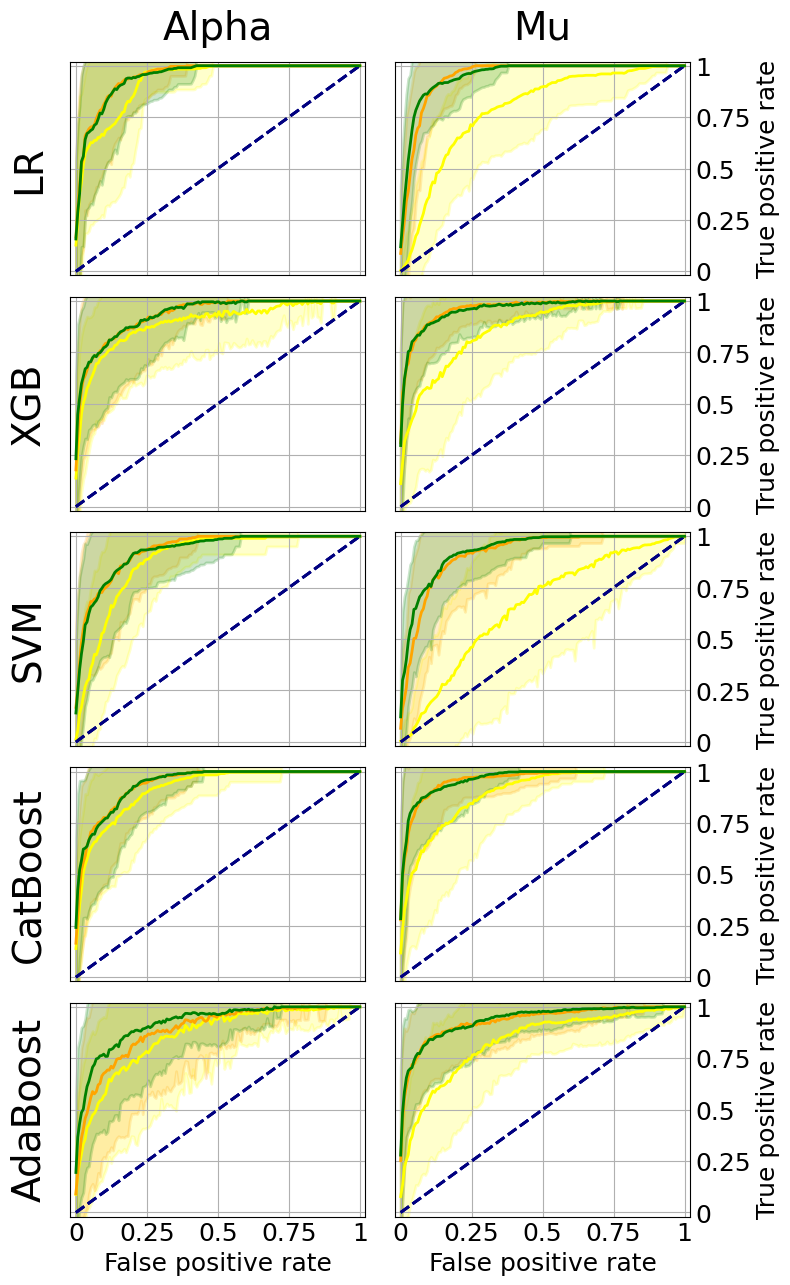

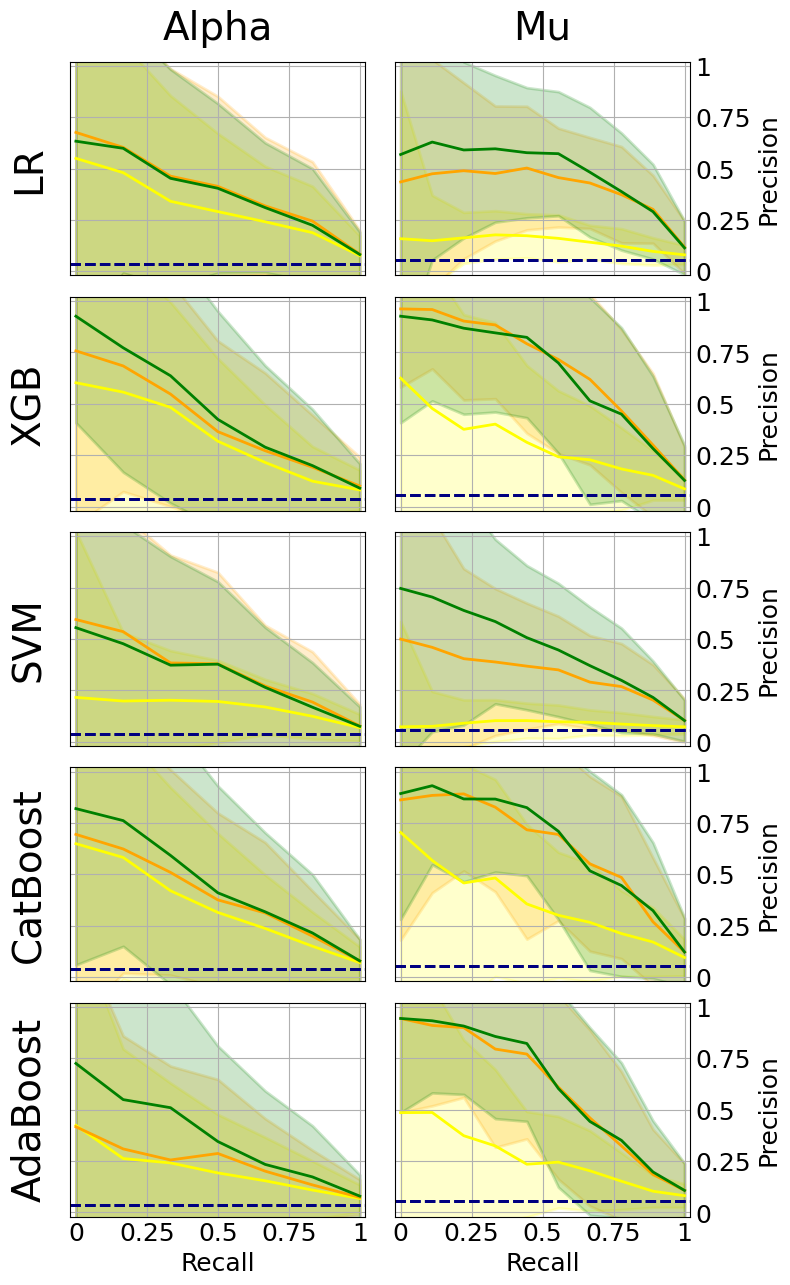

In [23]:
fig_roc, fig_pr, roc_aucs, pr_aucs, f1_scores, macro_f1_scores, confusion_matrices = plot_curves_grid([feature_old, feature_iteration_1, features], targets, models)

In [24]:
# Вывод всех метрик
display_metrics(roc_aucs, pr_aucs, f1_scores, macro_f1_scores, confusion_matrices)

ROC AUC for feature set 0:
          flag_alpha   flag_mu
LR          0.923159  0.789081
XGB         0.893072  0.865667
SVM         0.883791  0.659037
CatBoost    0.916209  0.894904
AdaBoost    0.857059  0.829459


ROC AUC for feature set 1:
          flag_alpha   flag_mu
LR          0.950479  0.948919
XGB         0.934782  0.965289
SVM         0.934510  0.916593
CatBoost    0.941155  0.963541
AdaBoost    0.888148  0.934852


ROC AUC for feature set 2:
          flag_alpha   flag_mu
LR          0.946536  0.954148
XGB         0.936002  0.961200
SVM         0.927756  0.932904
CatBoost    0.943769  0.966504
AdaBoost    0.922887  0.939289


PR AUC for feature set 0:
          flag_alpha   flag_mu
LR          0.419245  0.155183
XGB         0.441616  0.408115
SVM         0.202345  0.099514
CatBoost    0.431085  0.454385
AdaBoost    0.302249  0.328646


PR AUC for feature set 1:
          flag_alpha   flag_mu
LR          0.516113  0.454699
XGB         0.542608  0.774507
SVM         0.458380  

# Testing features on the combined Mu Rhythm+Kids dataset

In [64]:
path_kids = '/Users/beliaevaaleksandra/Downloads/dataset_kids_10.0'

data_kids, raw_annotations_kids = load_dataset(path_kids, preload=False)

In [65]:
annotations_kids = propogate_labels(raw_annotations_kids)
targets_kids = build_target_df(annotations_kids, weights='uniform', strategy='mean', threshold=0.33)

targets_kids[['flag_alpha', 'flag_mu', 'flag_heart']] = build_target_df(annotations_kids, 
                                                                        ['flag_alpha', 'flag_mu', 'flag_heart'], 
                                                                        strategy='majority')

print(targets_kids.sum())
targets_kids = targets_kids.loc[:, (targets_kids.mean(axis=0) > 0.05) & (targets_kids.all(axis=0) < 0.95)]

flag_brain       443
flag_alpha        52
flag_mu           54
flag_eyes         57
flag_eyes_h       11
flag_eyes_v       11
flag_muscles     142
flag_heart       131
flag_ch_noise     68
dtype: int64


In [66]:
targets_kids

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
ic_id,,,,,,,
IC000262,False,False,False,False,False,False,False
IC000263,True,False,False,False,False,False,False
IC000264,True,False,False,False,False,True,False
IC000265,True,False,False,False,False,False,False
IC000266,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...
IC000877,True,False,False,False,False,False,False
IC000878,True,False,False,False,True,False,False
IC000879,True,False,False,False,False,False,False


In [67]:
targets_kids = targets_kids.fillna(False)


In [68]:
targets_kids

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
ic_id,,,,,,,
IC000262,False,False,False,False,False,False,False
IC000263,True,False,False,False,False,False,False
IC000264,True,False,False,False,False,True,False
IC000265,True,False,False,False,False,False,False
IC000266,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...
IC000877,True,False,False,False,False,False,False
IC000878,True,False,False,False,True,False,False
IC000879,True,False,False,False,False,False,False


In [69]:
targets_kids.shape, len(data_kids.keys())

((620, 7), 620)

In [32]:
features_kids = build_feature_df(data_kids)

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use fl

In [33]:
features_kids = features_kids.loc[targets_kids.index]

In [70]:
targets_kids = targets_kids.drop(columns=[col for col in columns_to_drop if col in targets_kids.columns], errors='ignore')


In [71]:
targets_kids

,flag_alpha,flag_mu
ic_id,,
IC000262,False,False
IC000263,False,False
IC000264,False,False
IC000265,False,False
IC000266,False,False
...,...,...
IC000877,False,False
IC000878,False,False
IC000879,False,False


In [75]:
targets_combined = pd.concat([targets, targets_kids])

In [76]:
targets_combined = targets_combined.dropna(axis=1)

In [77]:
targets_combined

,flag_alpha,flag_mu
ic_id,,
IC001181,False,False
IC001182,False,False
IC001183,False,False
IC001184,False,False
IC001185,False,False
...,...,...
IC000877,False,False
IC000878,False,False
IC000879,False,False


In [37]:
features_combined = pd.concat([features, features_kids])

In [38]:
# Определяем необходимые колонки для feature_old и feature_iteration_1
columns_feature_old = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB']
columns_feature_iteration_1 = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB', 
                               'A_peaks', 'A_plateaus', 'A_peaks_freq', 'A_plateaus_freq', 'pca1', 'pca2']

# Создаем новые DataFrame с нужными колонками
features_old_combined  = features_combined[columns_feature_old]
features_iteration_1_combined  = features_combined[columns_feature_iteration_1]

In [ ]:
features_combined

In [39]:
features_combined.to_csv('features_Mu_Rhythm_Kids.csv')

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     16200
        True       0.43      0.03      0.05      1050

    accuracy                           0.94     17250
   macro avg       0.69      0.51      0.51     17250
weighted avg       0.91      0.94      0.91     17250

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     16200
        True       0.61      0.23      0.34      1050

    accuracy                           0.94     17250
   macro avg       0.78      0.61      0.65     17250
weighted avg       0.93      0.94      0.93     17250

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     16200
        True       0.60      0.27      0.37      1050

    accuracy                           0.94     17250

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     16200
        True       0.61      0.29      0.39      1050

    accuracy                           0.95     17250
   macro avg       0.78      0.64      0.68     17250
weighted avg       0.93      0.95      0.94     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     16200
        True       0.65      0.32      0.43      1050

    accuracy                           0.95     17250
   macro avg       0.80      0.65      0.70     17250
weighted avg       0.94      0.95      0.94     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     16200
        True       0.69      0.35      0.46      1050

    accuracy                           0.95     17250
   macro avg       0.82      0.67      0.72     17250
weighted avg       0.94      0.95      0.94     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.94      0.99      0.97     16000
        True       0.62      0.25      0.36      1250

    accuracy                           0.93     17250
   macro avg       0.78      0.62      0.66     17250
weighted avg       0.92      0.93      0.92     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     16000
        True       0.71      0.38      0.50      1250

    accuracy                           0.94     17250
   macro avg       0.83      0.68      0.73     17250
weighted avg       0.94      0.94      0.94     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     16000
        True       0.68      0.40      0.51      1250

    accuracy                           0.94     17250
   macro avg       0.82      0.69      0.74     17250
weighted avg       0.93      0.94      0.94     17250

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     16200
        True       0.00      0.00      0.00      1050

    accuracy                           0.94     17250
   macro avg       0.47      0.50      0.48     17250
weighted avg       0.88      0.94      0.91     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     16200
        True       0.00      0.00      0.00      1050

    accuracy                           0.94     17250
   macro avg       0.47      0.50      0.48     17250
weighted avg       0.88      0.94      0.91     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     16200
        True       0.54      0.01      0.01      1050

    accuracy                           0.94     17250
   macro avg       0.74      0.50      0.49     17250
weighted avg       0.92      0.94      0.91     17250

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.93      1.00      0.96     16000
        True       0.00      0.00      0.00      1250

    accuracy                           0.93     17250
   macro avg       0.46      0.50      0.48     17250
weighted avg       0.86      0.93      0.89     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.93      1.00      0.96     16000
        True       0.00      0.00      0.00      1250

    accuracy                           0.93     17250
   macro avg       0.46      0.50      0.48     17250
weighted avg       0.86      0.93      0.89     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.93      1.00      0.97     16000
        True       0.76      0.11      0.19      1250

    accuracy                           0.93     17250
   macro avg       0.85      0.55      0.58     17250
weighted avg       0.92      0.93      0.91     17250

Classification Report for CatBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     16200
        True       0.62      0.30      0.41      1050

    accuracy                           0.95     17250
   macro avg       0.79      0.64      0.69     17250
weighted avg       0.94      0.95      0.94     17250

Classification Report for CatBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     16200
        True       0.64      0.29      0.40      1050

    accuracy                           0.95

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     16200
        True       0.59      0.24      0.34      1050

    accuracy                           0.94     17250
   macro avg       0.77      0.61      0.65     17250
weighted avg       0.93      0.94      0.93     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     16200
        True       0.61      0.31      0.41      1050

    accuracy                           0.95     17250
   macro avg       0.78      0.65      0.69     17250
weighted avg       0.94      0.95      0.94     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     16200
        True       0.59      0.31      0.41      1050

    accuracy                           0.94     17250
   macro avg       0.77      0.65      0.69     17250
weighted avg       0.93      0.94      0.94     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.94      0.99      0.96     16000
        True       0.54      0.18      0.27      1250

    accuracy                           0.93     17250
   macro avg       0.74      0.59      0.62     17250
weighted avg       0.91      0.93      0.91     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.98      0.97     16000
        True       0.65      0.40      0.49      1250

    accuracy                           0.94     17250
   macro avg       0.80      0.69      0.73     17250
weighted avg       0.93      0.94      0.93     17250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97     16000
        True       0.64      0.41      0.50      1250

    accuracy                           0.94     17250
   macro avg       0.80      0.70      0.74     17250
weighted avg       0.93      0.94      0.93     17250



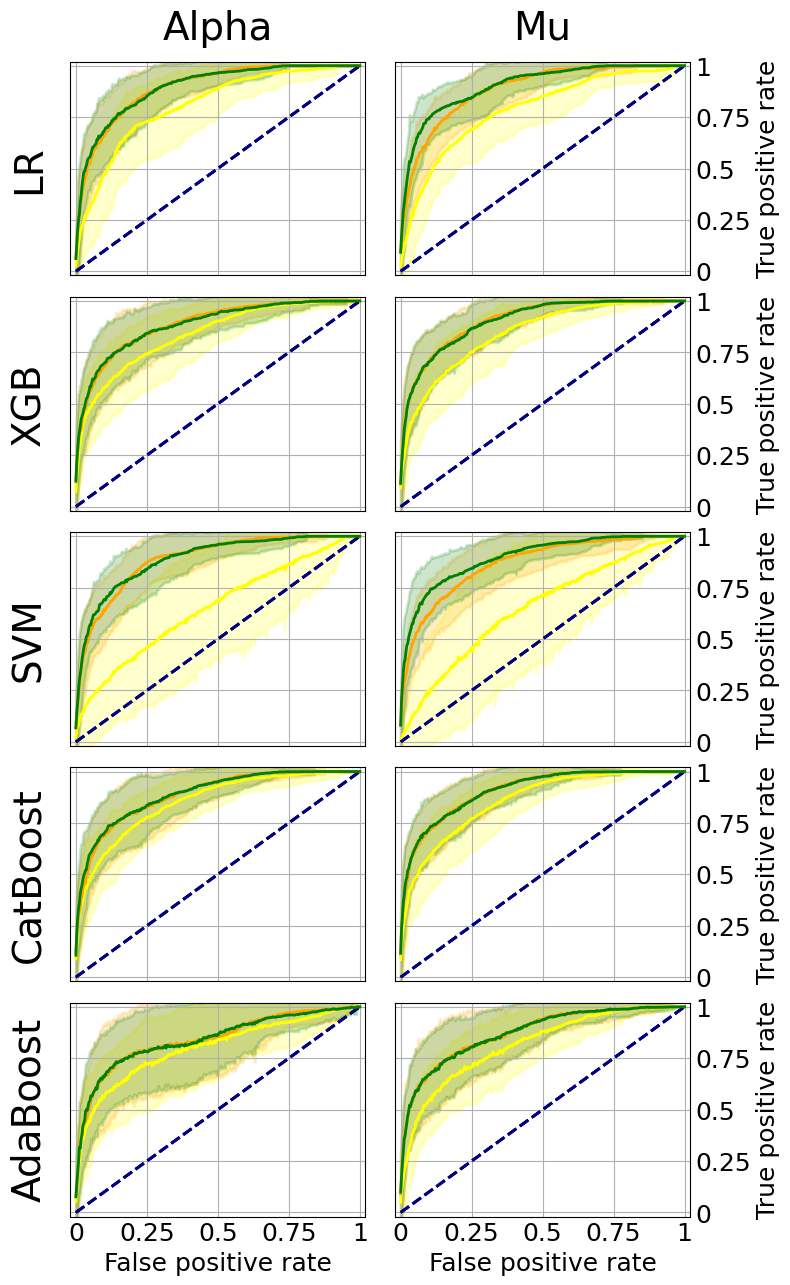

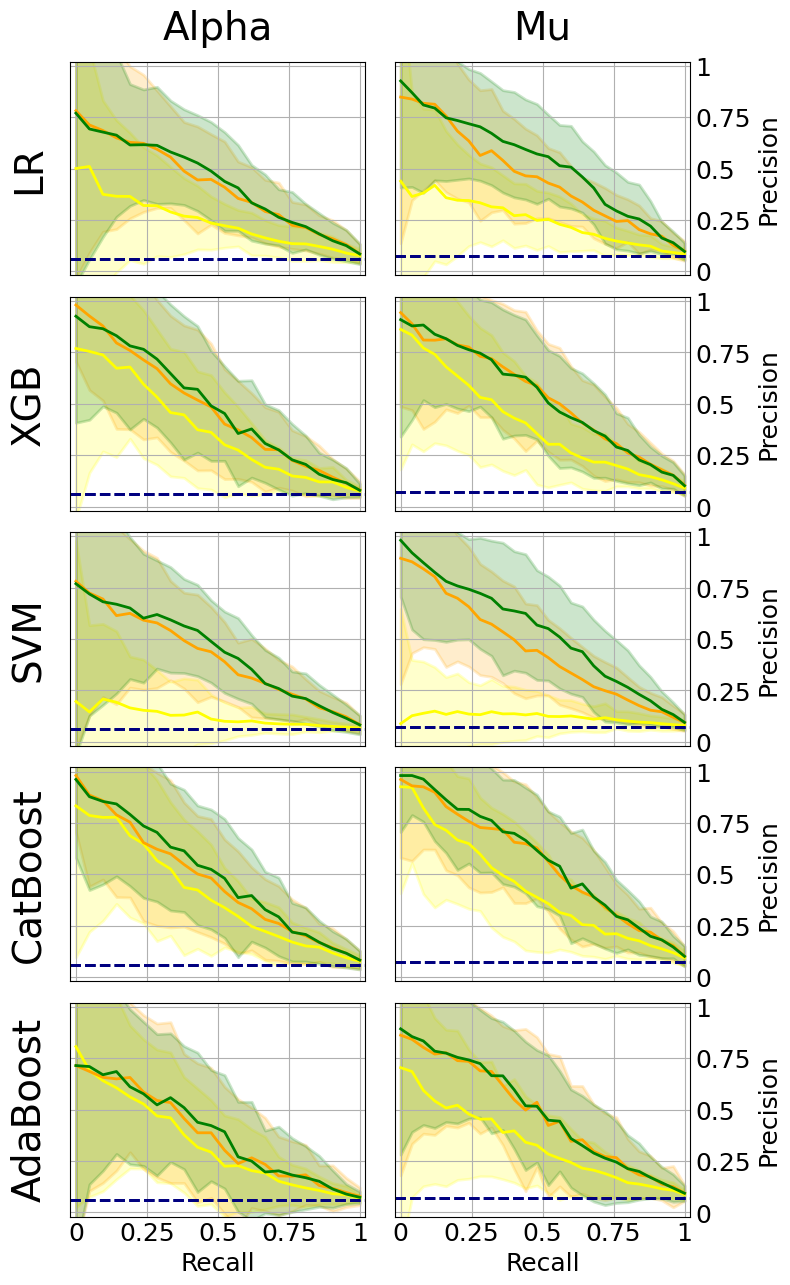

In [78]:
fig_roc_combined, fig_pr_combined, roc_aucs_combined, pr_aucs_combined, f1_scores_combined, macro_f1_scores_combined, confusion_matrices_combined = plot_curves_grid([features_old_combined, features_iteration_1_combined, features_combined], targets_combined, models)

In [79]:
display_metrics(roc_aucs_combined, pr_aucs_combined, f1_scores_combined, macro_f1_scores_combined, confusion_matrices_combined)

ROC AUC for feature set 0:
          flag_alpha   flag_mu
LR          0.809098  0.786502
XGB         0.837964  0.842885
SVM         0.651002  0.650224
CatBoost    0.853469  0.856900
AdaBoost    0.799615  0.816066


ROC AUC for feature set 1:
          flag_alpha   flag_mu
LR          0.895265  0.885650
XGB         0.887213  0.907507
SVM         0.888636  0.867897
CatBoost    0.887651  0.907720
AdaBoost    0.842294  0.874641


ROC AUC for feature set 2:
          flag_alpha   flag_mu
LR          0.895755  0.903605
XGB         0.885747  0.904533
SVM         0.890313  0.897745
CatBoost    0.892181  0.908135
AdaBoost    0.842068  0.874043


PR AUC for feature set 0:
          flag_alpha   flag_mu
LR          0.270371  0.266157
XGB         0.411334  0.428951
SVM         0.163046  0.138424
CatBoost    0.438319  0.454270
AdaBoost    0.377313  0.361946


PR AUC for feature set 1:
          flag_alpha   flag_mu
LR          0.451380  0.479464
XGB         0.514504  0.564522
SVM         0.441547  